In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

In [2]:
class RSLDS(nn.Module):
    def __init__(self, N, K, H, R, C_syn, device):
        super().__init__()
        
        self.N = N
        self.K = K
        self.H = H
        self.R = R
        self.device = device
        self.C_syn = C_syn
        self.in_no = C_syn.shape[1] 
        
        self.encoder = nn.GRU(N+1, R, num_layers=1, batch_first=True, bidirectional=True)
        self.Z_enc_lin = nn.Linear(2*R, self.N*self.K)
        self.X_enc_lin = nn.Linear(2*R, self.N*self.H)
        self.spike = nn.Parameter(torch.ones(self.in_no))
        
        self.W_zx = nn.Parameter(torch.zeros(self.N, self.K, self.K, self.H))
        self.W_zu = nn.Parameter(torch.zeros(self.N, self.K, self.K))
        self.b_z = nn.Parameter(torch.zeros(self.N, self.K, self.K))
        
        self.W_xx = nn.Parameter(torch.zeros(self.N, self.K, self.H, self.H))
        self.W_xu = nn.Parameter(torch.zeros(self.N, self.K, self.H))
        self.b_x = nn.Parameter(torch.zeros(self.N, self.K, self.H))
        
        self.W_yx = nn.Parameter(torch.ones(self.N * self.H))
        self.b_y = nn.Parameter(torch.zeros(1))
        
        self.Z0_raw = nn.Parameter(torch.zeros(self.N, self.K))
        
    def train_forward(self, U_raw, Y, temp):
        T_data = U_raw.shape[1]
        batch = U_raw.shape[0]
                
        U_scaled = U_raw * self.spike.reshape(1,1,-1)
        U = torch.matmul(U_scaled, self.C_syn.T) # (batch, T_data, N)
        
        enc_in = torch.zeros(batch, T_data, self.N+1).to(self.device)
        enc_in[:,:,0] = enc_in[:,:,0] + Y
        enc_in[:,:,1:] = enc_in[:,:,1:] + U
        
        # Encoder #
        encoder_out, _ = self.encoder(enc_in) # (batch, T_data, 2*R)
        Z_enc_raw = self.Z_enc_lin(encoder_out.reshape(-1, 2*self.R))
        Z_enc = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        Z_enc[:,1:,:,:] = Z_enc[:,1:,:,:] + F.softmax(Z_enc_raw.reshape(batch, T_data, self.N, self.K) / temp , 3)[:,1:,:,:]
        Z_enc[:,0,:,0] = 1
        X_enc = self.X_enc_lin(encoder_out.reshape(-1, 2*self.R))
        X_enc = X_enc.reshape(batch, T_data, self.N, self.H) # (batch, T, N, H)
                
        # Calculate X_dec X loss #
        X_old = torch.zeros(batch, T_data, self.N, self.H).to(self.device) # (batch, T, N, H)
        X_old[:,1:,:,:] = X_old[:,1:,:,:] + X_enc[:,:-1,:,:].clone()
        
        W_xx_part = torch.sum(Z_enc.unsqueeze(-1).unsqueeze(-1) * self.W_xx.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H, H)
        W_xu_part = torch.sum(Z_enc.unsqueeze(-1) * self.W_xu.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H)
        b_x_part = torch.sum(Z_enc.unsqueeze(-1) * self.b_x.unsqueeze(0).unsqueeze(0), 3) # (batch, T, N, H)
        
        X_dec = X_old + torch.matmul(W_xx_part , X_old.unsqueeze(-1)).squeeze(-1) \
            + W_xu_part * U.unsqueeze(-1) + b_x_part # (batch, T, N, H) 
        #X_prob = torch.sum(-(X_dec - X_enc.clone().detach())**2)
        X_prob = torch.sum(-(X_dec - X_enc.clone())**2)
        
        # Calculate Z_dec and Z loss #
        Z_dec = torch.zeros(batch, T_data, self.N, self.K).to(self.device) # just log prob
        Z_est = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        
        Z0_dec = F.softmax(self.Z0_raw, 0)
        #Z_dec[:,0,:,:] = Z_dec[:,0,:,:] + Z_enc[:,0,:,:].clone().detach() * torch.log(Z0_dec.unsqueeze(0)) # (batch, N, K)
        Z_dec[:,0,:,:] = Z_dec[:,0,:,:] + Z_enc[:,0,:,:].clone() * torch.log(Z0_dec.unsqueeze(0)) # (batch, N, K)
        Z_est[:,0,:,:] = Z0_dec
        
        Z_old = Z_enc[:,:-1,:,:].clone() # (batch, T-1, N, K)
        
        W_zx_part = torch.sum(Z_old.unsqueeze(-1).unsqueeze(-1) * self.W_zx.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K, H)
        W_zu_part = torch.sum(Z_old.unsqueeze(-1) * self.W_zu.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K)
        b_z_part = torch.sum(Z_old.unsqueeze(-1) * self.b_z.unsqueeze(0).unsqueeze(0), 3) # (batch, T-1, N, K)
        
        Zt_dec_raw = torch.matmul(W_zx_part , X_enc[:,:-1,:,:].clone().unsqueeze(-1)).squeeze(-1) \
            + W_zu_part * U[:,1:,:].unsqueeze(-1) + b_z_part
        Zt_dec = F.softmax(Zt_dec_raw / temp, 3) # (batch, T-1, N, K)
        #Z_dec[:,1:,:,:] = Z_dec[:,1:,:,:] + torch.log(Zt_dec) * Z_enc[:,1:,:,:].clone().detach()
        Z_dec[:,1:,:,:] = Z_dec[:,1:,:,:] + torch.log(Zt_dec) * Z_enc[:,1:,:,:].clone()
        Z_est[:,1:,:,:] = Zt_dec
        
        Z_prob = torch.sum(Z_dec)
        
        # Calculate Y loss #
        Y_enc = torch.sum(X_enc.reshape(batch, T_data, -1) * self.W_yx.reshape(1,1,-1), 2) + self.b_y # (batch, T)
        Y_prob = torch.sum(-(Y_enc - Y)**2)
        
        #total_prob = X_prob + Y_prob + Z_prob
        nan_count = torch.numel(torch.where(torch.isnan(X_dec) == True)[0])
        
        return Y_prob, X_prob, Z_prob, nan_count, Z_enc, Z_est
            
    def test_forward(self, U_raw, temp):
        T_data = U_raw.shape[1]
        batch = U_raw.shape[0]

        U_scaled = U_raw * self.spike.reshape(1,1,-1)
        U = torch.matmul(U_scaled, self.C_syn.T) # (batch, T_data, N)
        
        Z_out = torch.zeros(batch, T_data, self.N, self.K).to(self.device)
        X_out = torch.zeros(batch, T_data, self.N, self.H).to(self.device)
        Y_out = torch.zeros(batch, T_data).to(self.device)
        
        
        for t in range(T_data):
            # Calculate Z #
            if t == 0:
                curr_Z = F.softmax(self.Z0_raw/temp, 1)
                Z_out[:,t,:,:] = curr_Z.repeat(batch, 1, 1)
            else: # t in (1, T)
                W_zx_part = torch.sum(curr_Z.unsqueeze(-1).unsqueeze(-1) * self.W_zx.unsqueeze(0), 2) # (batch, N, K, H)
                W_zu_part = torch.sum(curr_Z.unsqueeze(-1) * self.W_zu.unsqueeze(0), 2) # (batch, N, K)
                b_z_part = torch.sum(curr_Z.unsqueeze(-1) * self.b_z.unsqueeze(0) , 2) # (batch, N, K)
                
                curr_Z_raw = torch.matmul(W_zx_part , curr_X.unsqueeze(-1)).squeeze(-1) \
                    + W_zu_part * U[:,t,:].unsqueeze(-1) + b_z_part
                
                """
                curr_Z = torch.zeros(batch, self.N, self.K).to(self.device)
                for b in range(batch):
                    for n in range(self.N):
                        idx = torch.argmax(curr_Z_raw[b,n,:])
                        curr_Z[b,n,idx] = 1
                """
                curr_Z = F.softmax(curr_Z_raw/temp, 2)
                
                Z_out[:,t,:,:] = curr_Z
            
            # Calculate X #
            if t == 0:
                curr_X = torch.zeros(batch, self.N, self.H).to(self.device)
                
            W_xx_part = torch.sum(curr_Z.unsqueeze(-1).unsqueeze(-1) * self.W_xx.unsqueeze(0), 2) # (batch, N, H, H)
            W_xu_part = torch.sum(curr_Z.unsqueeze(-1) * self.W_xu.unsqueeze(0), 2) # (batch, N, H)
            b_x_part = torch.sum(curr_Z.unsqueeze(-1) * self.b_x.unsqueeze(0), 2) # (batch, N, H)
            
            curr_X = curr_X + torch.matmul(W_xx_part , curr_X.unsqueeze(-1)).squeeze(-1) \
                + W_xu_part * U[:,t,:].unsqueeze(-1) + b_x_part # (batch, N, H)
            
            X_out[:,t,:,:] = curr_X
            
        # Calculate Y #
        Y_out = torch.sum(X_out.reshape(batch, T_data, -1) * self.W_yx.reshape(1,1,-1), 2) + self.b_y
        
        nan_count = torch.numel(torch.where(torch.isnan(Y_out) == True)[0])
        print(nan_count)
        
        return Y_out, X_out, Z_out
            

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

In [4]:
T_train = 996 * 1000 * 50
T_test = 1 * 1000 * 50
hid_no = 3 # H
sub_no = 4 # N
state_no = 3 # K
enc_no = 15
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 12
iter_no = 9960
epoch_no = iter_no*batch_length*batch_size//T_train

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = RSLDS(sub_no, state_no, hid_no, enc_no, C_syn, device)

etc_params = [model.W_xx, model.W_xu, model.b_x, model.W_yx, model.b_y]
enc_params = [model.spike]
Z_params = [model.W_zx, model.W_zu, model.b_z, model.Z0_raw]

for params in model.encoder.parameters():
    enc_params.append(params)
for params in model.Z_enc_lin.parameters():
    enc_params.append(params)
for params in model.X_enc_lin.parameters():
    enc_params.append(params)

enc_optimizer = torch.optim.Adam(enc_params, lr = 0.001)
Z_optimizer = torch.optim.Adam(Z_params, lr = 0.005)
etc_optimizer = torch.optim.Adam(etc_params, lr = 0.001)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optimizer, step_size=25, gamma=0.91)
Z_scheduler = torch.optim.lr_scheduler.StepLR(Z_optimizer, step_size=25, gamma=0.91)
etc_scheduler = torch.optim.lr_scheduler.StepLR(etc_optimizer, step_size=25, gamma=0.91)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3408


In [ ]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    enc_optimizer.zero_grad()
    Z_optimizer.zero_grad()
    etc_optimizer.zero_grad()
    #optimizer.zero_grad()
    
    if (i%25 == 24) & (temp_count < 49):
        temp_count += 1
        print("Inverse Temperature:", np.round(1 / temp_list[temp_count], 6))
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    Y_prob, X_prob, Z_prob, nan_no, Z_enc, Z_est = model.train_forward(batch_E_neural[:,:,e_idx], batch_V, temp)
    loss = -1*Y_prob - X_prob - Z_prob
    print(i, np.round(-Y_prob.item(), 6),
          np.round(-X_prob.item(), 6),
          np.round(-Z_prob.item(), 6),
         np.round(time.time() - s, 4), nan_no)
        
    loss.backward()
    enc_optimizer.step()
    Z_optimizer.step()
    etc_optimizer.step()
    
    #optimizer.step()
    #scheduler.step()
    enc_scheduler.step()
    Z_scheduler.step()
    etc_scheduler.step()
    
    if (i%50 == 49) and (i > 300):
        model.eval()
        test_V_pred, test_X, test_Z = model.test_forward(test_E_neural[:,e_idx].unsqueeze(0), temp)        
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print("TEST", i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-1cfd08df3fd8>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


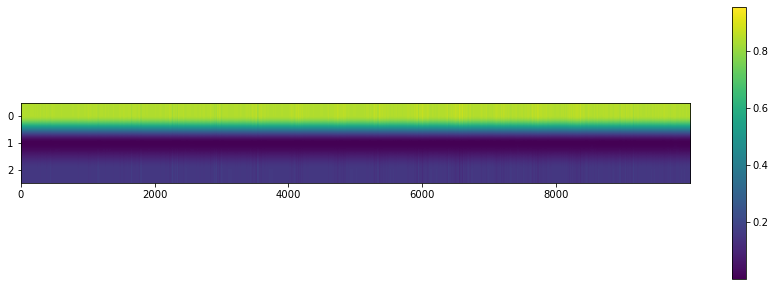

In [17]:
plt.figure(figsize = (15,5))
plt.imshow(Z_enc[3,16000:26000,1,:].cpu().detach().numpy().T, aspect=400)
plt.colorbar()

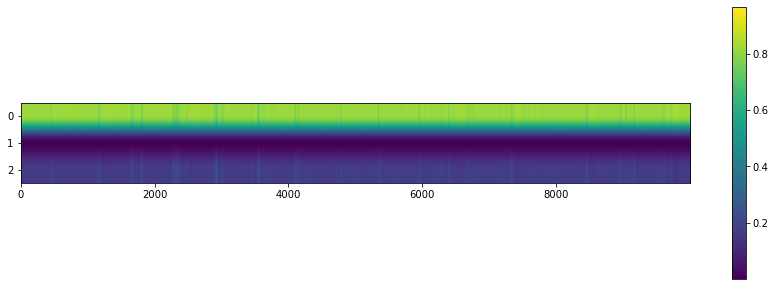

In [18]:
plt.figure(figsize = (15,5))
plt.imshow(Z_est[3,16000:26000,1,:].cpu().detach().numpy().T, aspect=400)
plt.colorbar()

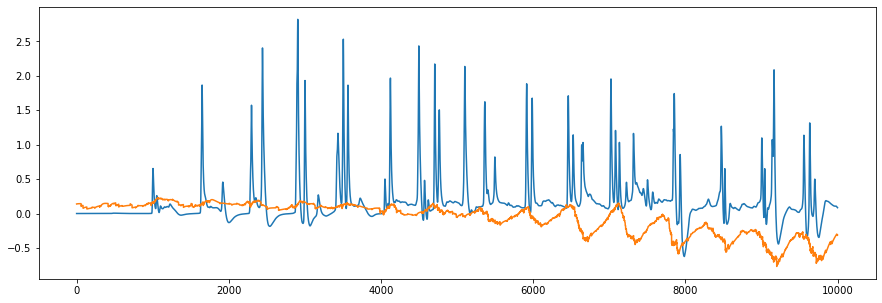

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[16000:26000])

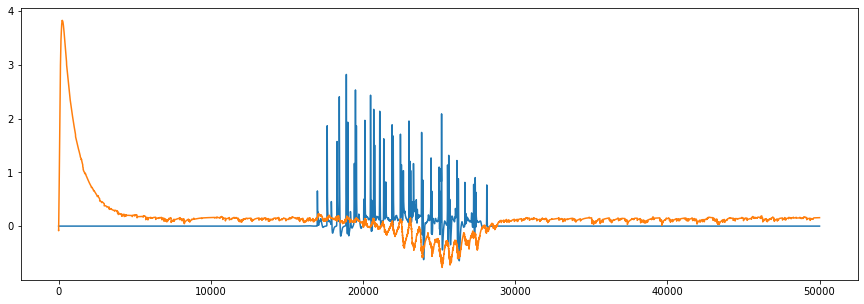

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.flatten().cpu().detach().numpy())

In [13]:
Z_out = np.zeros((50000,4))

for t in range(50000):
    for n in range(4):
        Z_out[t,n] = torch.argmax(test_Z[0,t,n])

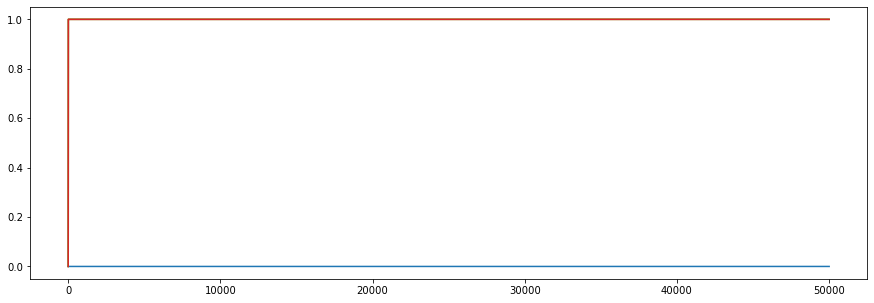

In [15]:
plt.figure(figsize = (15,5))

for n in range(4):
    plt.plot(Z_out[:,n])

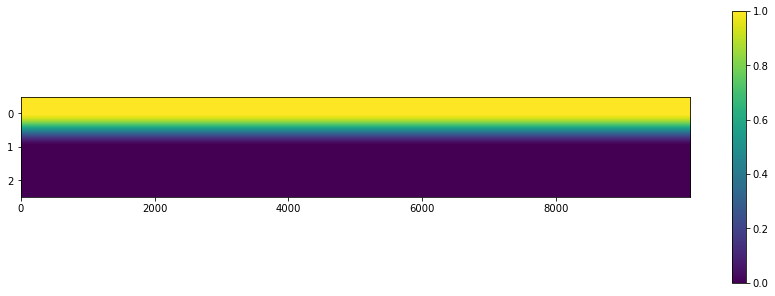

In [25]:
plt.figure(figsize = (15,5))
plt.imshow(test_Z[0,16000:26000,0].cpu().detach().numpy().T, aspect=500)
plt.colorbar()